# ch03.04_순환신경망 - Bidirectional-LSTM
---

* 날짜:
* 이름:


## 학습내용
    - 순환 신경망에 대해 이해한다.
    - BiLSTM
    - 로이터 뉴스기사 카테고리 분류
    - 스팀 리뷰 걈성 분류

```
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning
```

In [1]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning

Cloning into 'SkillTreePython-DeepLearning'...
remote: Enumerating objects: 1124, done.
remote: Counting objects: 100% (1124/1124), done.
remote: Compressing objects: 100% (555/555), done.
remote: Total 1124 (delta 623), reused 1035 (delta 554), pack-reused 0
Receiving objects: 100% (1124/1124), 58.00 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (623/623), done.


```
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *
```

In [2]:
import sys
sys.path.append('/content/SkillTreePython-DeepLearning/scripts')
from import_lib import *
from plot_result import *

## 로이터 뉴스 기사 분류
---

### | 데이터 전처리 

#### **데이터 불러오기**

In [3]:
MAX_FEATURES=1000  # 데이터에 1000개 단어만 포함하기
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=MAX_FEATURES)
print('훈련 데이터:',x_train.shape, y_train.shape)
print('테스트 데이터:',x_test.shape, y_test.shape)

2121728/2110848 [==============================] - 0s 0us/step
훈련 데이터: (8982,) (8982,)
테스트 데이터: (2246,) (2246,)


#### **데이터 확인**

In [4]:
print('첫번째 기사', x_train[0]) # 토큰화, 단어 인덱싱이 된 상태
print('첫번째 기사의 카테고리', y_train[0])
print('카테고리 개수:', np.max(y_train)+1) # 클래스가 0~45

첫번째 기사 [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫번째 기사의 카테고리 3
카테고리 개수: 46


뉴스 기사의 평균길이: 145.5398574927633


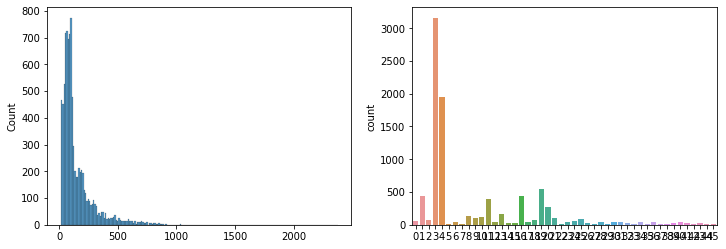

In [5]:
# 뉴스 기사의 평균 길이
plt.figure(figsize=(12,4))
len_sample = [len(x) for x in x_train]
plt.subplot(121);sns.histplot(x=len_sample)
plt.subplot(122);sns.countplot(x=y_train)
print('뉴스 기사의 평균길이:', np.mean(len_sample))

In [6]:
# 데이터 전처리 : 패딩
MAX_LEN = 128
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_LEN)
print('훈련 데이터:',x_train.shape, y_train.shape)
print('테스트 데이터:',x_test.shape, y_test.shape)

훈련 데이터: (8982, 128) (8982,)
테스트 데이터: (2246, 128) (2246,)


### | 임베딩 매트릭스 제작

```
! gdown https://drive.google.com/u/0/uc?id=1ams5_zp8NrfmbxSzTDCglRpAvjFGi5JY&export=download
! unzip  /content/glove.6B.zip
```


In [9]:
! gdown http://nlp.stanford.edu/data/glove.6B.zip
! unzip /content/glove.6B.zip

Downloading...
From: http://nlp.stanford.edu/data/glove.6B.zip
To: /content/glove.6B.zip
100% 862M/862M [02:39<00:00, 5.40MB/s]
Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


#### **단어-임베딩 딕셔너리**

```
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
```

In [10]:
f = open('/content/glove.6B.100d.txt', encoding='utf8')
word2embedding = {}
for line in f:
  word = line.split()[0] # 가장 첫번째가 단어
  vec = line.split()[1:] # 그 후는 단어에 대한 벡터
  vec = np.asarray(vec, dtype='float32')
  #print(word,len(vec))
  #break
  word2embedding[word] = vec     # 딕셔너리 dic[key] = value 추가하는방법
f.close()

#### **인덱싱-단어 딕셔너리**

In [11]:
word2index = tf.keras.datasets.reuters.get_word_index()
#print(word2index)
index2word = {}
for word, index in word2index.items():
  index2word[index+3]=word
print(index2word)

565248/550378 [==============================] - 0s 0us/step
{10999: 'mdbl', 16263: 'fawc', 12092: 'degussa', 8806: 'woods', 13799: 'hanging', 20675: 'localized', 20676: 'sation', 20678: 'chanthaburi', 11000: 'refunding', 8807: 'hermann', 20679: 'passsengers', 20680: 'stipulate', 8355: 'heublein', 20716: 'screaming', 16264: 'tcby', 188: 'four', 1645: 'grains', 20683: 'broiler', 12093: 'wooden', 1223: 'wednesday', 13800: 'highveld', 7596: 'duffour', 20684: '0053', 3917: 'elections', 2566: '270', 3554: '271', 5116: '272', 3555: '273', 3403: '274', 7978: 'rudman', 3404: '276', 3481: '277', 3635: '278', 4312: '279', 9384: 'dormancy', 7250: 'errors', 3089: 'deferred', 20686: 'sptnd', 8808: 'cooking', 20687: 'stratabit', 16265: 'designing', 20688: 'metalurgicos', 13801: 'databank', 20689: '300er', 20690: 'shocks', 7975: 'nawg', 20691: 'tnta', 20692: 'perforations', 2894: 'affiliates', 20693: '27p', 16266: 'ching', 598: 'china', 16267: 'wagyu', 3192: 'affiliated', 16268: 'chino', 16269: 'chin

In [12]:
for x in x_train[0]:
  if index2word.get(x) is not None:
    print(index2word[x]) #1000개의 단어 외에는 생략되기 때문

said
as
a
result
of
its
december
acquisition
of
co
it
expects
earnings
per
share
in
1987
of
1
15
to
1
30
dlrs
per
share
up
from
70
cts
in
1986
the
company
said
pretax
net
should
rise
to
nine
to
10
mln
dlrs
from
six
mln
dlrs
in
1986
and
revenues
to
19
to
22
mln
dlrs
from
12
5
mln
dlrs
it
said
cash
per
share
this
year
should
be
2
50
to
three
dlrs
reuter
3


#### **매트릭스 제작**

In [13]:
embed_mx = np.zeros((MAX_FEATURES, 100))
for idx in range(4, 1004):
  word = index2word[idx]
  embed = word2embedding.get(word) # 딕셔너리.get 함수는 없으면 None값 반환
  #print(word, embed)
  if embed is not None:
    embed_mx[idx-4] = embed

### | 모델학습 1

이때까지 배운 레이어를 사용하여 모델을 구축하세요.

```
Embedding()
RNN()
LSTM()
GRU()
GlobalAveragePooling1D()
Dense()
```

In [14]:
EMB_DIMS = 100
x = layers.Input(shape=MAX_LEN)
y = layers.Embedding(MAX_FEATURES, EMB_DIMS)(x)
y = layers.GRU(64, return_sequences=True)(y)
y = layers.GRU(64, return_sequences=True)(y)
y = layers.GlobalAveragePooling1D()(y)
y = layers.Dense(46, activation='softmax')(y)
model = models.Model(x,y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 100)          100000    
                                                                 
 gru (GRU)                   (None, 128, 64)           31872     
                                                                 
 gru_1 (GRU)                 (None, 128, 64)           24960     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 46)                2990      
                                                             

In [15]:
import numpy as np

timesteps = 10
input_dim = 4
hidden_units = 8

# 입력에 해당되는 2D 텐서
inputs = np.random.random((timesteps, input_dim))

# 초기 은닉 상태는 0(벡터)로 초기화
hidden_state_t = np.zeros((hidden_units,)) 

print('초기 은닉 상태 :',hidden_state_t)

초기 은닉 상태 : [0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
len(inputs)

10

In [17]:
model.layers[1].set_weights([embed_mx])

Epoch 1/20
71/71 [==============================] - 9s 25ms/step - loss: 2.4725 - acc: 0.3709 - val_loss: 2.1289 - val_acc: 0.4541
Epoch 2/20
71/71 [==============================] - 1s 14ms/step - loss: 2.0272 - acc: 0.4875 - val_loss: 1.9317 - val_acc: 0.5303
Epoch 3/20
71/71 [==============================] - 1s 14ms/step - loss: 1.7948 - acc: 0.5583 - val_loss: 1.7087 - val_acc: 0.5877
Epoch 4/20
71/71 [==============================] - 1s 14ms/step - loss: 1.6004 - acc: 0.6072 - val_loss: 1.6034 - val_acc: 0.6104
Epoch 5/20
71/71 [==============================] - 1s 14ms/step - loss: 1.4834 - acc: 0.6365 - val_loss: 1.5432 - val_acc: 0.6358
Epoch 6/20
71/71 [==============================] - 1s 14ms/step - loss: 1.3957 - acc: 0.6595 - val_loss: 1.4671 - val_acc: 0.6402
Epoch 7/20
71/71 [==============================] - 1s 15ms/step - loss: 1.3038 - acc: 0.6785 - val_loss: 1.4083 - val_acc: 0.6563
Epoch 8/20
71/71 [==============================] - 1s 14ms/step - loss: 1.2421 - a

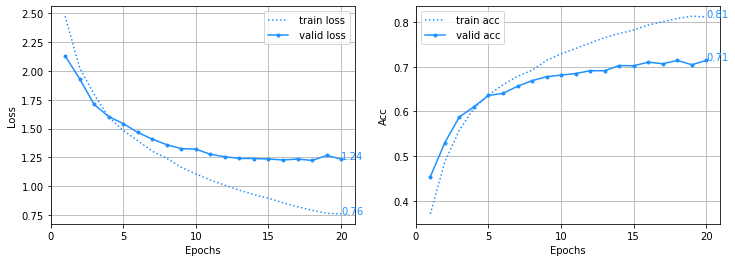

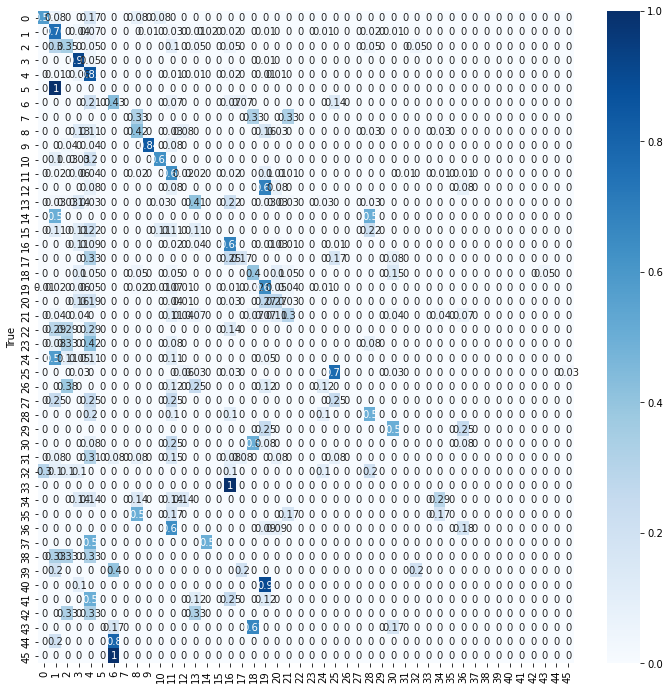

In [18]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
history=model.fit(x_train,y_train,
                  batch_size=128,
                  epochs=20,
                  validation_data=(x_test,y_test))
plot_lcurve([history],[''],['dodgerblue'],x_itv=5)
draw_cm(model,x_test,y_test)

### | 모델학습 2

![](https://www.researchgate.net/profile/Arvind-Mohan-3/publication/324769532/figure/fig2/AS:619510805561344@1524714294669/LSTM-and-BiLSTM-Architectures.png)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 100)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 128, 128)         63744     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 128)         74496     
 nal)                                                            
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                           

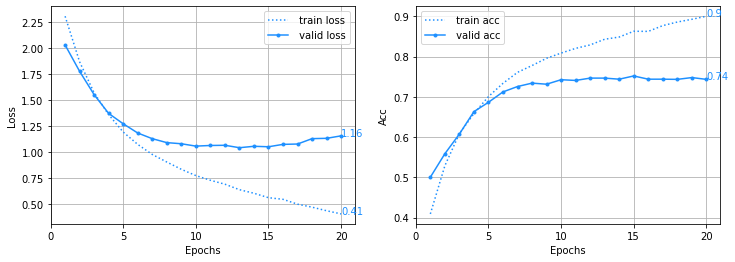

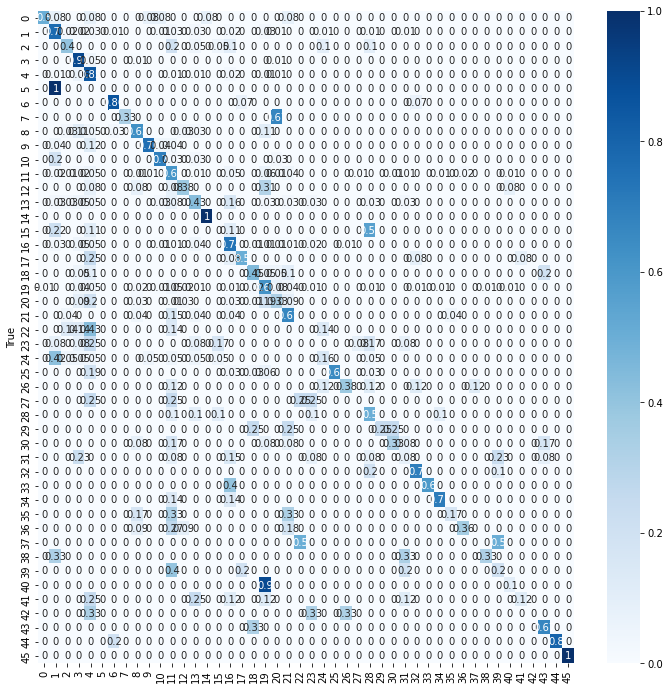

In [19]:
EMB_DIMS = 100
x = layers.Input(shape=MAX_LEN)
y = layers.Embedding(MAX_FEATURES, EMB_DIMS)(x)
y = layers.Bidirectional(layers.GRU(64, return_sequences=True))(y)
y = layers.Bidirectional(layers.GRU(64, return_sequences=True))(y)
y = layers.GlobalAveragePooling1D()(y)
y = layers.Dense(46, activation='softmax')(y)
model = models.Model(x,y)
model.summary()
model.layers[1].set_weights([embed_mx])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
history=model.fit(x_train,y_train,
                  batch_size=128,
                  epochs=20,
                  validation_data=(x_test,y_test))
plot_lcurve([history],[''],['dodgerblue'],x_itv=5)
draw_cm(model,x_test,y_test)

## 스팀 리뷰 감성 분류
---

https://wikidocs.net/94748

```
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
```

In [20]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 4.98 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 34.0 MB/s 
     |████████████████████████████████| 453 kB 94.3 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-09-13 06:53:21--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (b

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7f34d67fe950>)

In [23]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


In [24]:
# 데이터 전처리

total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


In [25]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


In [26]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [27]:
# 테스트 데이터

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


전처리 후 테스트용 샘플의 개수 : 24973


In [28]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [29]:
mecab = Mecab() 

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs) # 토큰화
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords]) # 불용어 적용

# 테스트 데이터
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [30]:
# 긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠습니다. 각 레이블에 따라서 별도로 단어들의 리스트를 저장해줍니다.

negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

# Counter()를 사용하여 각 단어에 대한 빈도수를 카운트합니다. 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력합니다.

negative_word_count = Counter(negative_words)
print('부정 리뷰:', negative_word_count.most_common(20))
positive_word_count = Counter(positive_words)
print('긍정 리뷰:', positive_word_count.most_common(20))

부정 리뷰: [('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]
긍정 리뷰: [('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


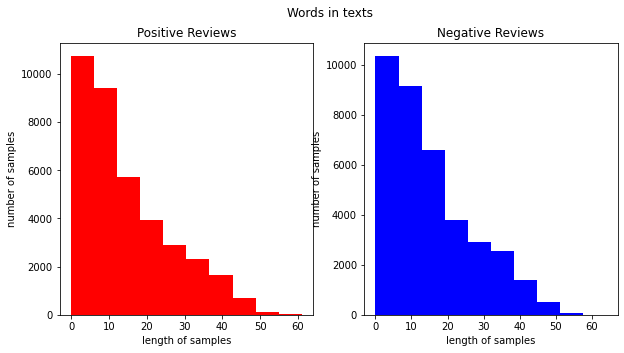

In [31]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [32]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # 단어 인덱싱

In [34]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold(2)보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold(2)보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold(2)보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 희귀 단어의 수: 13878
단어 집합에서 희귀 단어의 비율: 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2254607619437832


In [35]:
# 단어가 약 32,000개가 존재합니다. 
# 등장 빈도가 threshold 값인 2회 미만. 즉, 1회인 단어들은 단어 집합에서 약 42%를 차지합니다. 
# 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 1.2%밖에 되지 않습니다. 
# 아무래도 등장 빈도가 1회인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다. 등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [36]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2

In [37]:
# 단어 집합의 크기는 18,941개입니다. 이를 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환합니다. 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다.

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


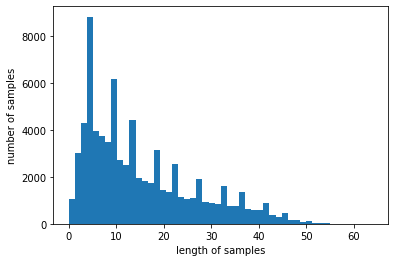

In [38]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [39]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


In [40]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [41]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.5214 - acc: 0.7407
Epoch 1: val_acc improved from -inf to 0.77876, saving model to best_model.h5
235/235 [==============================] - 8s 19ms/step - loss: 0.5214 - acc: 0.7407 - val_loss: 0.4698 - val_acc: 0.7788
Epoch 2/15
233/235 [============================>.] - ETA: 0s - loss: 0.4309 - acc: 0.8055
Epoch 2: val_acc improved from 0.77876 to 0.78250, saving model to best_model.h5
235/235 [==============================] - 4s 16ms/step - loss: 0.4308 - acc: 0.8055 - val_loss: 0.4678 - val_acc: 0.7825
Epoch 3/15
233/235 [============================>.] - ETA: 0s - loss: 0.4045 - acc: 0.8201
Epoch 3: val_acc improved from 0.78250 to 0.79078, saving model to best_model.h5
235/235 [==============================] - 4s 16ms/step - loss: 0.4045 - acc: 0.8202 - val_loss: 0.4553 - val_acc: 0.7908
Epoch 4/15
233/235 [============================>.] - ETA: 0s - loss: 0.3813 - acc: 0.8323
Epoch 4: val_acc did not impro

In [42]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [43]:
sentiment_predict('재밌을 것이라고 생각하고 보면 후회함') 

53.77% 확률로 긍정 리뷰입니다.
